In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-28 21:59:29.311329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 21:59:29.326590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 21:59:29.326771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 21:59:29.327428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import glob
from tqdm import tqdm
import re

In [38]:
all_captions = []
all_img_name_vector = []


with open('./words_captcha/spec_train_val.txt') as fin:
    for line in fin:
        image_name, caption = line.strip().split()
        all_img_name_vector.append(f'./words_captcha/{image_name}.png')
        all_captions.append('<start> ' + ' '.join(caption) + ' <end>')

test_img_name = set(glob.glob(f'./words_captcha/*.png')) - set(all_img_name_vector)
all_img_name_vector += sorted(test_img_name)


tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                                                  oov_token='')
tokenizer.fit_on_texts(all_captions)
cap_seqs = tokenizer.texts_to_sequences(all_captions)

cap_seqs = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')
max_length = len(cap_seqs[0])



num_train = 100000
num_valid = 20000
img_name_train, img_name_valid, img_name_test  = all_img_name_vector[:num_train], all_img_name_vector[num_train:num_train+num_valid], all_img_name_vector[num_train+num_valid:]
train_seqs, valid_seqs = cap_seqs[:num_train], cap_seqs[num_train:]


In [4]:
len(train_seqs), len(all_captions)

(100000, 120000)

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE


In [7]:
IMAGE_SIZE = (160, 300)

In [8]:
def map_func(img_name, cap):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    return img, cap


In [9]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, train_seqs))\
                               .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, valid_seqs))\
                               .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)


In [10]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 15, embedding_dim)
        # hidden shape == (batch_size, hidden_size)

        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 15, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, 15, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector == (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)

        return context_vector, attention_weights


In [11]:
from tensorflow.keras import layers


class conv_leaky_relu(layers.Layer):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv_2d = layers.Conv2D(filters, size, stride, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.leakey_relu = layers.LeakyReLU(0.1)

    def call(self, inputs):
        x = self.conv_2d(inputs)
        x = self.batch_norm(x)
        x = self.leakey_relu(x)
        return x


In [12]:
from tensorflow.keras import Input, layers, Model

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = conv_leaky_relu(64, 7, 2)(inputs)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(192, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(128, 1, 1)(x)
x = conv_leaky_relu(256, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 2)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
outputs = conv_leaky_relu(1024, 3, 1)(x)

feature_extractor = Model(inputs=inputs, outputs=outputs, name='YOLO')
feature_extractor.summary()


Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 300, 3)]     0         
_________________________________________________________________
conv_leaky_relu (conv_leaky_ (None, 80, 150, 64)       9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 75, 64)        0         
_________________________________________________________________
conv_leaky_relu_1 (conv_leak (None, 40, 75, 192)       111552    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 37, 192)       0         
_________________________________________________________________
conv_leaky_relu_2 (conv_leak (None, 20, 37, 128)       25216     
_________________________________________________________________
conv_leaky_relu_3 (conv_leak (None, 20, 37, 256)       296192 

In [13]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # x shape after passing through fc == (batch_size, 15, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [14]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # x shape == (batch_size, 1)
        # features shape == (batch_size, 15, embedding_dim)
        # hidden shape == (batch_size, hidden_size)

        # context_vector shape == (batch_size, embedding_dim)
        # attention_weights shape == (batch_size, 15, 1)
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # output shape == (batch_size, 1, hidden_size)
        # state(hidden) shape == (batch_size, hidden_size)
        output, state = self.gru(x)

        # x shape == (batch_size, 1, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [15]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [16]:
optimizer = tf.keras.optimizers.Adam(5e-5)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [17]:
checkpoint_path = './checkpoints/train/'
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [18]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])


In [19]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [20]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    batch_size = img_tensor.shape[0]
    hidden = decoder.reset_state(batch_size=batch_size)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    with tf.GradientTape() as tape:
        features = feature_extractor(img_tensor, True)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = feature_extractor.trainable_variables + encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [21]:
EPOCHS = 10
start = time.time()
for epoch in range(start_epoch, EPOCHS):

    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(tqdm(dataset_train, total=num_steps)):
        batch_loss, t_loss= train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps)) 

print('Time taken for {} epoch {} sec\n'.format(EPOCHS - start_epoch, time.time() - start))


  0%|          | 0/1000 [00:00<?, ?it/s]2023-11-28 21:59:33.801286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-11-28 21:59:39.969663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8500
2023-11-28 21:59:40.097168: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-28 21:59:42.945305: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-11-28 21:59:42.990048: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could b

Epoch 1 Loss 1.680886


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 2 Loss 0.643459


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 3 Loss 0.127397


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 4 Loss 0.051217


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 5 Loss 0.030278


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 6 Loss 0.021954


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 7 Loss 0.017864


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 8 Loss 0.015396


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 9 Loss 0.012178


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 10 Loss 0.010023
Time taken for 10 epoch 3245.447103738785 sec



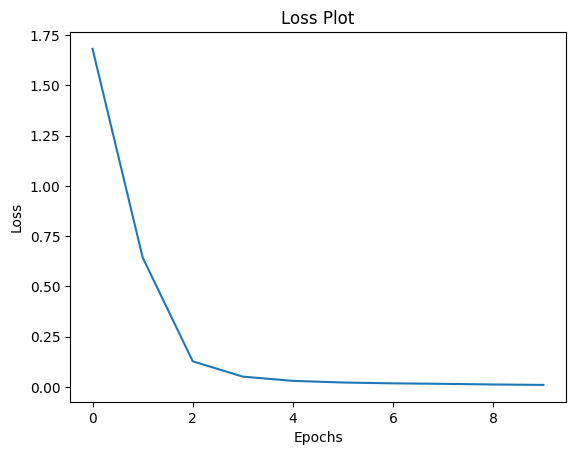

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [41]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * batch_size, 1)

    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    hidden = decoder.reset_state(batch_size=batch_size)

    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result


In [42]:
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt.restore('./checkpoints/train/ckpt-10')


In [43]:
def map_func2(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    return img, img_path

In [44]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(map_func2, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(100)\
                              .prefetch(tf.data.experimental.AUTOTUNE)


In [45]:
with open('./Lab12-2_112062559.txt', 'w') as f:
    for step, (img_tensor, img_path) in enumerate(dataset_test):
        predictions = []
        for seq in predict(img_tensor).numpy():
            result = ''
            for s in seq[1:]:
                if s == tokenizer.word_index['<end>']:
                    break
                result += tokenizer.index_word[s]
            predictions.append(result)

        for path, pred in zip(img_path, predictions):
            path = path.numpy().decode('utf-8')
            name = re.search('(a[0-9]+)', path).group(1)
            f.write(f'{name} {pred}\n')


In [46]:
total_num = 0
correct_num = 0
for img_tensor, target in dataset_valid:
    predictions = []
    for seq in predict(img_tensor).numpy():
        result = ''
        for s in seq[1:]:
            if s == tokenizer.word_index['<end>']:
                break
            result += tokenizer.index_word[s]
        predictions.append(result)

    answers = []
    for seq in target.numpy():
        result = ''
        for s in seq[1:]:
            if s == tokenizer.word_index['<end>']:
                break
            result += tokenizer.index_word[s]
        answers.append(result)

    for pred, ans in zip(predictions, answers):
        total_num += 1
        if pred == ans:
            correct_num += 1

print(f'testing accuracy : {correct_num / total_num:.3f}')

testing accuracy : 0.952


## Report
我用了範例中的attention-based model,其中唯一不同的地方是feature extractor的地方把原本的inception_v3換成YOLO。總共訓練了10個EPOCHS後得到的testing accuracy是0.952
